In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import scipy.stats
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.neighbors
import sklearn.ensemble
import sklearn.feature_selection
import unittest

import sklearn.datasets
import sklearn.tree

import optuna

***Import dataset/ML code from other notebook***

In [2]:
cd /Users/loganroberts/Learn2Therm/ValidProt/data

/Users/loganroberts/Learn2Therm/ValidProt/data


In [8]:
#convert to pandas df
df = pd.read_csv('learn2therm_sample_50k/learn2therm_sample_50k.csv')

In [9]:
df.head()

,Unnamed: 0,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,thermo_index,...,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_seq,t_protein_seq,m_protein_desc,t_protein_desc,m_protein_len,t_protein_len
0,0,0.287582,0.217822,0.215686,160,0.792079,152,0.737864,131,875,...,1153.0,27.5,50.0,22.5,MAESGTSRRADHLVPVPGPDAEPPAVADELLRAVGRGDEQAFGRLY...,MPSQITESERIELAERFERDALPLLDQLYSAALRMTRNPADAEDLV...,ECF RNA polymerase sigma factor SigK,sigma-70 family RNA polymerase sigma factor,206,202
1,1,0.319635,0.295359,0.297872,218,0.919831,226,0.969957,282,11324,...,1014.0,25.0,54.0,29.0,MARIALVDDDRNILTSVSMTLEAEGFEVETYNDGQSALDAFNKRMP...,MRVLLVEDDPNTSRSIEMMLTHANLNVYATDMGEEGIDLAKLYDYD...,response regulator transcription factor,response regulator transcription factor,233,237
2,2,0.279621,0.234127,0.218924,211,0.837302,210,0.731707,96,875,...,1138.0,28.0,50.0,22.0,MKDTVVFVTGAARGIGAHTARLAVARGARVALVGLEPHLLADLAAE...,MTPEQIFSGQTAIVTGGASGIGAATVEHIARRGGRVFSVDLSYDSP...,SDR family oxidoreductase,SDR family oxidoreductase,287,252
3,3,0.327273,0.200743,0.214712,166,0.617100,163,0.696581,175,875,...,1077.0,28.0,50.0,22.0,MTSGLWERVLDGVWVTIQLLVLSALLATAVSFVVGIARTHRLWIVR...,MAMSRRKRGQLARGIQYAILVIVVVVLALLADWGKIGKAFFDWEAA...,ectoine/hydroxyectoine ABC transporter permeas...,amino acid ABC transporter permease,234,269
4,4,0.338710,0.318182,0.287671,60,0.909091,71,0.887500,61,9827,...,991.0,30.0,50.0,20.0,MIISLRRGLRFIRFIVFFAALVYLFYHVLDLFNGWISPVDQYQMPT...,MKRMVWRTLKVFIIFIACTLLFYFGLRFMHLEYEQFHRYEPPEGPA...,YqzK family protein,YqzK family protein,80,66


The following cells are attempts at creating a classification column. Having trouble with the code. Gonna create a dummy.

Update: turn categories into a dictionary and iterate through

ESM - can return a continuous represenation of an AA sequence. Look up repo for ESM

start by testing on a single sequence 

In [10]:
# #isolate the categories that appear more than 500 times

# categories = df_original['t_protein_desc'].value_counts()
# categories = categories.iloc[categories.values > 500]
# categories_dict = {item: None for item in categories.index}

# list_of_cats = list(categories_dict.keys())
# list_of_cats

In [11]:
# df = df_original[df_original.t_protein_desc.isin(list_of_cats)]
# df.shape

In [12]:
df['protein_match'] = df['t_protein_desc'] == df['m_protein_desc']
df['protein_match'].head()

0    False
1     True
2     True
3    False
4     True
Name: protein_match, dtype: bool

In [13]:
df['protein_match'].value_counts()

False    25737
True     24263
Name: protein_match, dtype: int64

In [14]:
#get rid of stuff that isn't quantitative

df = df.drop(columns = ['Unnamed: 0','thermo_index', 'm_protein_seq', 't_protein_seq',
                        'm_protein_desc', 't_protein_desc'])

In [15]:
df.head()

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,meso_index,prot_pair_index,...,scaled_local_symmetric_percent_id_16s,query_align_cov_16s,subject_align_cov_16s,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_len,t_protein_len,protein_match
0,0.287582,0.217822,0.215686,160,0.792079,152,0.737864,131,12897,48641291,...,0.926461,0.998040,0.998020,1153.0,27.5,50.0,22.5,206,202,False
1,0.319635,0.295359,0.297872,218,0.919831,226,0.969957,282,13026,92992745,...,0.902522,1.000000,1.000000,1014.0,25.0,54.0,29.0,233,237,True
2,0.279621,0.234127,0.218924,211,0.837302,210,0.731707,96,8203,157628663,...,0.923531,1.000000,1.000000,1138.0,28.0,50.0,22.0,287,252,True
3,0.327273,0.200743,0.214712,166,0.617100,163,0.696581,175,3340,136708305,...,0.909745,0.996734,0.996726,1077.0,28.0,50.0,22.0,234,269,False
4,0.338710,0.318182,0.287671,60,0.909091,71,0.887500,61,14020,133672542,...,0.887107,0.998084,0.998067,991.0,30.0,50.0,20.0,80,66,True


from pairplot below, it looks like query_align_cov_16s and subject_align_cov_16s dont correlate with anything

In [16]:
# sns.pairplot(df.sample(500),height = 4)

#i dont see much higher-order correlation, so it's likely we can use linear regression

In [17]:
df = df.drop(columns = ['query_align_cov_16s', 'subject_align_cov_16s'])

In [18]:
df.describe()

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,meso_index,prot_pair_index,...,taxa_pair_index,local_gap_compressed_percent_id_16s,scaled_local_query_percent_id_16s,scaled_local_symmetric_percent_id_16s,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_len,t_protein_len
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,5.000000e+04,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.349026,0.276478,0.270792,206.011660,0.791507,205.414920,0.770875,230.63206,8098.858120,9.105934e+07,...,362827.905140,0.906828,0.903266,0.904959,1061.404480,27.348365,51.505410,24.157045,269.985200,261.367700
std,0.096608,0.114404,0.116039,64.260901,0.144893,64.430548,0.179955,186.44859,4608.982941,5.233883e+07,...,229264.926253,0.015240,0.015626,0.015300,75.659661,3.737201,3.816972,3.586797,65.935753,69.675548
min,0.164103,0.081301,0.045977,19.000000,0.284553,19.000000,0.082019,35.00000,5.000000,1.219000e+03,...,4885.000000,0.876590,0.836055,0.880026,891.000000,7.000000,41.000000,20.000000,30.000000,27.000000
25%,0.293750,0.204545,0.202020,172.000000,0.673288,172.000000,0.656854,118.00000,4121.000000,4.645832e+07,...,173976.750000,0.895995,0.893020,0.893531,1009.000000,27.000000,50.000000,22.000000,233.000000,226.000000
50%,0.325000,0.250000,0.244648,210.000000,0.811321,209.000000,0.806584,186.00000,8046.000000,9.160212e+07,...,312362.000000,0.905983,0.902326,0.903543,1056.000000,28.000000,52.500000,24.500000,267.000000,260.000000
75%,0.367257,0.308300,0.301639,240.000000,0.923077,240.000000,0.923077,267.00000,12103.000000,1.360713e+08,...,617814.000000,0.916172,0.912576,0.914698,1108.000000,29.000000,52.500000,24.500000,317.000000,311.000000
max,0.985075,0.985075,0.985075,400.000000,1.000000,399.000000,1.000000,1788.00000,16564.000000,1.814866e+08,...,744518.000000,0.999351,0.993544,0.996439,1679.000000,40.000000,78.000000,56.000000,400.000000,400.000000


In [19]:
df.head()

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,meso_index,prot_pair_index,...,local_gap_compressed_percent_id_16s,scaled_local_query_percent_id_16s,scaled_local_symmetric_percent_id_16s,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_len,t_protein_len,protein_match
0,0.287582,0.217822,0.215686,160,0.792079,152,0.737864,131,12897,48641291,...,0.924640,0.921620,0.926461,1153.0,27.5,50.0,22.5,206,202,False
1,0.319635,0.295359,0.297872,218,0.919831,226,0.969957,282,13026,92992745,...,0.901907,0.900068,0.902522,1014.0,25.0,54.0,29.0,233,237,True
2,0.279621,0.234127,0.218924,211,0.837302,210,0.731707,96,8203,157628663,...,0.920812,0.919007,0.923531,1138.0,28.0,50.0,22.0,287,252,True
3,0.327273,0.200743,0.214712,166,0.617100,163,0.696581,175,3340,136708305,...,0.912730,0.908556,0.909745,1077.0,28.0,50.0,22.0,234,269,False
4,0.338710,0.318182,0.287671,60,0.909091,71,0.887500,61,14020,133672542,...,0.889389,0.883142,0.887107,991.0,30.0,50.0,20.0,80,66,True


<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


Text(0, 0.5, 'Count')

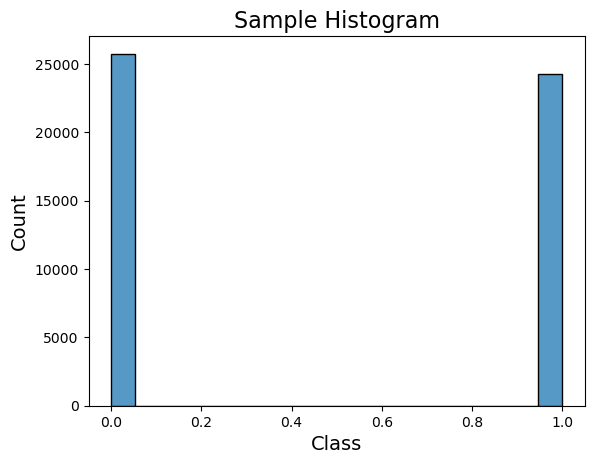

In [20]:
#plot empirical distribution of scaled_local_query_percent_id

target = df['protein_match']
#create histplot
fig, ax = plt.subplots()

sns.histplot(data = df, x = target)

ax.set_title('Sample Histogram', fontsize=16)
ax.set_xlabel('Class', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

In [21]:
# print('The mean is: {} and the standard deviation is: {}.'.format(target.mean(),target.std())) 

# print('The minimum bit score is: {} and the maximum bit score is: {}.'.format(target.min(),target.max()))

1) Split dev and test data:

In [22]:
df = df.drop(columns = ['meso_index', 'meso_protein_int_index', 'local_gap_compressed_percent_id_16s', 
                        'scaled_local_query_percent_id_16s', 'scaled_local_symmetric_percent_id_16s',
                       'bit_score_16s', 'm_ogt', 't_ogt', 'taxa_pair_index', 'thermo_protein_int_index'
                       , 'prot_pair_index', 'ogt_difference'])

In [23]:
#choosing 80/20 split instead of 85/15 because of volume of data

dev, test = sklearn.model_selection.train_test_split(df, test_size=0.15, random_state=1)

#might want to name the above split train/val, since we don't really have "test data" yet
train, val = sklearn.model_selection.train_test_split(dev, test_size=0.15, random_state=1)

print(dev.shape)
print(test.shape)
print(train.shape)
print(val.shape)

(42500, 11)
(7500, 11)
(36125, 11)
(6375, 11)


In [24]:
target = 'protein_match'
input_features = [columns for columns in df]
input_features.remove(target)

In [25]:
print(input_features)
print(target)

['local_gap_compressed_percent_id', 'scaled_local_query_percent_id', 'scaled_local_symmetric_percent_id', 'query_align_len', 'query_align_cov', 'subject_align_len', 'subject_align_cov', 'bit_score', 'm_protein_len', 't_protein_len']
protein_match


In [26]:
# predicting values 

dev_X = dev[input_features].values
test_X = test[input_features].values

dev_y = dev[target].values.reshape(-1,1)
test_y = test[target].values.reshape(-1,1)  

print(dev_X.shape, test_X.shape, dev_y.shape, test_y.shape)

(42500, 10) (7500, 10) (42500, 1) (7500, 1)


In [27]:
train_X = train[input_features].values
val_X = val[input_features].values

train_y = train[target].values.reshape(-1,1)
val_y = val[target].values.reshape(-1,1) 

2) Scale the data

In [28]:
scaler = sklearn.preprocessing.StandardScaler()
dev_X = scaler.fit_transform(dev_X)
test_X = scaler.fit_transform(test_X)
train_X = scaler.fit_transform(train_X)
val_X = scaler.fit_transform(val_X)

3) Regularize the data -L1 or L2? Read online

4. Train the model

In [103]:
#Random Forest

model = sklearn.ensemble.RandomForestClassifier(n_estimators=150, max_depth=None, max_samples=0.5,
                                                max_features=0.5, min_weight_fraction_leaf=0.000215,
                                               min_samples_split=10)
model.fit(dev_X, dev_y.ravel())

RandomForestClassifier(max_features=0.5, max_samples=0.5, min_samples_split=10,
                       min_weight_fraction_leaf=0.000215, n_estimators=150)

5. Test the model, report relevant statistics

In [104]:
score = model.score(test_X, test_y)
print('Model score is: {}'.format(score))

preds = model.predict(test_X)
print(preds)

Model score is: 0.6785333333333333
[False False False ...  True False False]


In [106]:
#try bagging

from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(sklearn.ensemble.RandomForestClassifier(n_estimators=150, max_depth=None, min_weight_fraction_leaf=0.000215),
                             max_samples=0.5, max_features=0.5)

In [107]:
bagging.fit(dev_X, dev_y.ravel())

BaggingClassifier(estimator=RandomForestClassifier(min_weight_fraction_leaf=0.000215,
                                                   n_estimators=150),
                  max_features=0.5, max_samples=0.5)

In [108]:
bagging.score(test_X, test_y)

0.6761333333333334

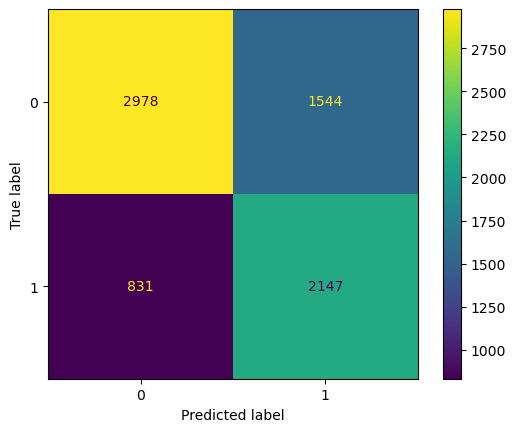

In [81]:
#confusion matrix

confusion_matrix = sklearn.metrics.confusion_matrix(preds, test_y)
sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix).plot()

**Start with Random Forest Classifier**

Random Search

In [96]:
# create hyperparameter value options for each hyperparameter
max_depth_options = [1,2,3,4,5]
min_weight_fraction_options = [0, 0.1, 0.2, 0.3, 0.4]
max_sample_options = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
min_samples_split_options = [i for i in range(20)]

In [97]:
# Define the grid of hyperparameter options

param_grid = {
    'max_depth': max_depth_options,
    'min_weight_fraction_leaf': min_weight_fraction_options,
    'n_estimators': [50,100,150,200],
    'min_samples_split': min_samples_split_options,
    'max_samples': max_sample_options
}
# Create the grid search object
# Give it the model we want to use, the hyperparameters to search over
#CV param does cross validation for me
random_search = sklearn.model_selection.RandomizedSearchCV(
    sklearn.ensemble.RandomForestClassifier(),
    param_grid,
    cv=5
)
# execute the grid search
random_search.fit(dev_X, dev_y.ravel())

print('Best hyperparameters: ', random_search.best_params_)

/Users/loganroberts/opt/anaconda3/envs/validprot/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/loganroberts/opt/anaconda3/envs/validprot/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/loganroberts/opt/anaconda3/envs/validprot/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/Users/loganroberts/opt/anaconda3/envs/validprot/lib/python3.10/site-pack

Best hyperparameters:  {'n_estimators': 150, 'min_weight_fraction_leaf': 0.1, 'min_samples_split': 11, 'max_samples': 0.6, 'max_depth': 5}


In [59]:
model = sklearn.ensemble.RandomForestClassifier(n_estimators=50, min_weight_fraction_leaf=0.0002153178126766452, max_depth=5)
model.fit(dev_X, dev_y.ravel())
print(model.score(test_X, test_y))

0.6572


TPE with Optuna

In [43]:
def train_evaluate_hyperparameters(max_depth, min_weight_fraction_leaf, n_estimators):
    
    # create RF classifier model
    model = sklearn.ensemble.RandomForestClassifier(max_depth=max_depth, min_weight_fraction_leaf=min_weight_fraction_leaf,
                                               n_estimators=n_estimators)
    
    # train the model on the training set
    fit = model.fit(train_X, train_y)
    
    # evaluate the model on the validation set
    score = model.score(val_X, val_y)
    
    return score

In [44]:
def id_best_hyperparams(trial):
    # define hyperparameter space
    max_depth_options = trial.suggest_int('max_depth_options', 1, 5)
    min_weight_fraction_options = trial.suggest_uniform("min_weight_fraction_options", 0,0.4)
    n_estimator_options = trial.suggest_int('n_estimators', 50, 200, 50)
    
    # get the score for the hyperparameters chosen
    score = train_evaluate_hyperparameters(max_depth=max_depth_options, min_weight_fraction_leaf=min_weight_fraction_options,
                                          n_estimators=n_estimator_options)
    
    return score

study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
study.optimize(id_best_hyperparams, n_trials=50)
print('Best params: ', study.best_params)

[I 2023-03-12 13:19:38,933] A new study created in memory with name: no-name-4a3a10a2-a838-463f-8093-16731f23f717
/var/folders/1n/stf1qksj3jb8f79pgwq8cslc0000gn/T/ipykernel_33089/172233721.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  min_weight_fraction_options = trial.suggest_uniform("min_weight_fraction_options", 0,0.4)
/var/folders/1n/stf1qksj3jb8f79pgwq8cslc0000gn/T/ipykernel_33089/1086670810.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fit = model.fit(train_X, train_y)
[I 2023-03-12 13:19:41,019] Trial 0 finished with value: 0.6252549019607843 and parameters: {'max_depth_options': 2, 'min_weight_fraction_options': 0.2546725523337537, 'n_estimators': 150}. Best is trial 0 with value: 0.62525

/var/folders/1n/stf1qksj3jb8f79pgwq8cslc0000gn/T/ipykernel_33089/172233721.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  min_weight_fraction_options = trial.suggest_uniform("min_weight_fraction_options", 0,0.4)
/var/folders/1n/stf1qksj3jb8f79pgwq8cslc0000gn/T/ipykernel_33089/1086670810.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fit = model.fit(train_X, train_y)
[I 2023-03-12 13:19:59,045] Trial 9 finished with value: 0.6305882352941177 and parameters: {'max_depth_options': 3, 'min_weight_fraction_options': 0.2248206823993893, 'n_estimators': 200}. Best is trial 3 with value: 0.6547450980392157.
/var/folders/1n/stf1qksj3jb8f79pgwq8cslc0000gn/T/ipykernel_33089/172233721.py:4: FutureWarning: sugge

/var/folders/1n/stf1qksj3jb8f79pgwq8cslc0000gn/T/ipykernel_33089/172233721.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  min_weight_fraction_options = trial.suggest_uniform("min_weight_fraction_options", 0,0.4)
/var/folders/1n/stf1qksj3jb8f79pgwq8cslc0000gn/T/ipykernel_33089/1086670810.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fit = model.fit(train_X, train_y)
[I 2023-03-12 13:20:31,065] Trial 18 finished with value: 0.6538039215686274 and parameters: {'max_depth_options': 5, 'min_weight_fraction_options': 0.03731496790099021, 'n_estimators': 150}. Best is trial 10 with value: 0.6625882352941177.
/var/folders/1n/stf1qksj3jb8f79pgwq8cslc0000gn/T/ipykernel_33089/172233721.py:4: FutureWarning: su

/var/folders/1n/stf1qksj3jb8f79pgwq8cslc0000gn/T/ipykernel_33089/172233721.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  min_weight_fraction_options = trial.suggest_uniform("min_weight_fraction_options", 0,0.4)
/var/folders/1n/stf1qksj3jb8f79pgwq8cslc0000gn/T/ipykernel_33089/1086670810.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fit = model.fit(train_X, train_y)
[I 2023-03-12 13:21:02,855] Trial 27 finished with value: 0.6436078431372549 and parameters: {'max_depth_options': 3, 'min_weight_fraction_options': 0.06972724408230972, 'n_estimators': 200}. Best is trial 21 with value: 0.6629019607843137.
/var/folders/1n/stf1qksj3jb8f79pgwq8cslc0000gn/T/ipykernel_33089/172233721.py:4: FutureWarning: su

/var/folders/1n/stf1qksj3jb8f79pgwq8cslc0000gn/T/ipykernel_33089/172233721.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  min_weight_fraction_options = trial.suggest_uniform("min_weight_fraction_options", 0,0.4)
/var/folders/1n/stf1qksj3jb8f79pgwq8cslc0000gn/T/ipykernel_33089/1086670810.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fit = model.fit(train_X, train_y)
[I 2023-03-12 13:21:33,667] Trial 36 finished with value: 0.6552156862745098 and parameters: {'max_depth_options': 5, 'min_weight_fraction_options': 0.036522333347455964, 'n_estimators': 200}. Best is trial 21 with value: 0.6629019607843137.
/var/folders/1n/stf1qksj3jb8f79pgwq8cslc0000gn/T/ipykernel_33089/172233721.py:4: FutureWarning: s

/var/folders/1n/stf1qksj3jb8f79pgwq8cslc0000gn/T/ipykernel_33089/172233721.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  min_weight_fraction_options = trial.suggest_uniform("min_weight_fraction_options", 0,0.4)
/var/folders/1n/stf1qksj3jb8f79pgwq8cslc0000gn/T/ipykernel_33089/1086670810.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fit = model.fit(train_X, train_y)
[I 2023-03-12 13:22:04,812] Trial 45 finished with value: 0.652235294117647 and parameters: {'max_depth_options': 4, 'min_weight_fraction_options': 0.07047230968284193, 'n_estimators': 150}. Best is trial 42 with value: 0.6630588235294118.
/var/folders/1n/stf1qksj3jb8f79pgwq8cslc0000gn/T/ipykernel_33089/172233721.py:4: FutureWarning: sug

Best params:  {'max_depth_options': 5, 'min_weight_fraction_options': 0.0020952848886019093, 'n_estimators': 150}


Let's define a function that can optimize hyperparameters for any model architecture we might be interested in.